**Reference**:

https://towardsdatascience.com/how-to-fine-tune-an-nlp-regression-model-with-transformers-and-huggingface-94b2ed6f798f

https://predictivehacks.com/how-to-fine-tune-an-nlp-regression-model-with-transformers-and-huggingface/


# Linear Regression 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformers
from datasets import Dataset,load_dataset, load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from transformers.utils import logging
logging.set_verbosity_error()

## Create AutoTokenizer

In [2]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

## Pandas To Dataset

In [3]:
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler


columns = ['text','wip','activity_nlp','resource_nlp','case_nlp']

def make_dataset(dataset, iloc_from, iloc_to):
    df_ = dataset[columns].iloc[iloc_from:iloc_to]  
    df_[['wip']] = MinMaxScaler().fit_transform(df_[['wip']])
    df_= df_.rename(columns={"wip": "labels"})

    df_.reset_index(inplace=True,drop=True)
    return df_

df = pd.read_csv('df_nlp_real.csv',usecols=columns,dtype={'wip':'float'})
df_nlp = make_dataset(df, 200,300)
display(df_nlp.head(3))

dataset = Dataset.from_pandas(df_nlp[['text','labels']],preserve_index=False) 
dataset = dataset.train_test_split(test_size=0.3) 

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

dataset

,text,labels,activity_nlp,resource_nlp,case_nlp
0,R2 starts A3 on C1030 at 2010-02-22 12:05,0.800000,A3,R2,C1030
1,R2 starts A1 on C1328 at 2010-02-22 13:00,0.000000,A1,R2,C1328
2,R2 starts A2 on C1328 at 2010-02-22 13:01,0.816667,A2,R2,C1328


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 70
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 30
    })
})

In [6]:
# df = pd.read_csv('df_nlp_real.csv',usecols=columns,dtype={'wip':'float'})
# df.head(3)

## Tokenization & How To Add New Tokens


In [7]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

token_columns = ['activity_nlp','resource_nlp','case_nlp']
for x in token_columns:
    for y in df_nlp[x].unique():
        tokenizer.add_tokens(y)
        
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# add separators : , - , at, on 
# add hour, min as  00 , 01 , 59
# add 2010, 2011

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

#### Test Tokenization

In [8]:
text = df_nlp["text"][0]
tokens = tokenizer(text)['input_ids']
actual_tokens = [tokenizer.decode(i) for i in tokens]

print(f'text  :{text} \ntokens:{tokens} \nactual token:{actual_tokens}')

text  :R2 starts A3 on C1030 at 2010-02-22 12:05 
tokens:[101, 30529, 4627, 30522, 2006, 30536, 2012, 2230, 1011, 6185, 1011, 2570, 2260, 1024, 5709, 102] 
actual token:['[CLS]', 'R2', 'starts', 'A3', 'on', 'C1030', 'at', '2010', '-', '02', '-', '22', '12', ':', '05', '[SEP]']


## Fine-Tuning The Model

In [9]:
from transformers import AutoModelForSequenceClassification

# num_labels =1 means regression
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)
model.resize_token_embeddings(len(tokenizer))

Embedding(30581, 768)

### Metrics Function


In [10]:
from datasets import load_metric
from sklearn.metrics import mean_squared_error
import evaluate

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    rmse = mean_squared_error(labels, predictions, squared=False)
    return {"rmse": rmse}

def compute_metrics_mape(eval_pred):
    predictions, labels = eval_pred
    mape = mape_metric.compute(predictions=predictions, references=labels)
    return {"mape": mape}

### Train The Model

In [11]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer",
                                  logging_strategy="epoch",
                                  evaluation_strategy="epoch",
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  num_train_epochs=3,
                                  save_total_limit = 2,
                                  save_strategy = 'no',
                                  load_best_model_at_end=False,
                                  report_to="none"
                                  )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics
)
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/yousef/miniforge3/envs/mlp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 70
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 15
  Number of trainable parameters = 66999553
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClass

{'loss': 0.3639, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}
{'eval_loss': 0.17678673565387726, 'eval_rmse': 0.42046016454696655, 'eval_runtime': 3.5231, 'eval_samples_per_second': 8.515, 'eval_steps_per_second': 0.568, 'epoch': 1.0}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 16


{'loss': 0.1569, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}
{'eval_loss': 0.1290789693593979, 'eval_rmse': 0.35927557945251465, 'eval_runtime': 3.446, 'eval_samples_per_second': 8.706, 'eval_steps_per_second': 0.58, 'epoch': 2.0}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 16


{'loss': 0.1189, 'learning_rate': 0.0, 'epoch': 3.0}




Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 0.07285371422767639, 'eval_rmse': 0.26991426944732666, 'eval_runtime': 3.5421, 'eval_samples_per_second': 8.47, 'eval_steps_per_second': 0.565, 'epoch': 3.0}
{'train_runtime': 106.3156, 'train_samples_per_second': 1.975, 'train_steps_per_second': 0.141, 'train_loss': 0.21320125261942546, 'epoch': 3.0}


TrainOutput(global_step=15, training_loss=0.21320125261942546, metrics={'train_runtime': 106.3156, 'train_samples_per_second': 1.975, 'train_steps_per_second': 0.141, 'train_loss': 0.21320125261942546, 'epoch': 3.0})

# Train and test chart and metrics

In [12]:
predictions_test = trainer.predict(tokenized_datasets["test"])
predictions_train = trainer.predict(tokenized_datasets["train"])

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 30
  Batch size = 16
The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 70
  Batch size = 16


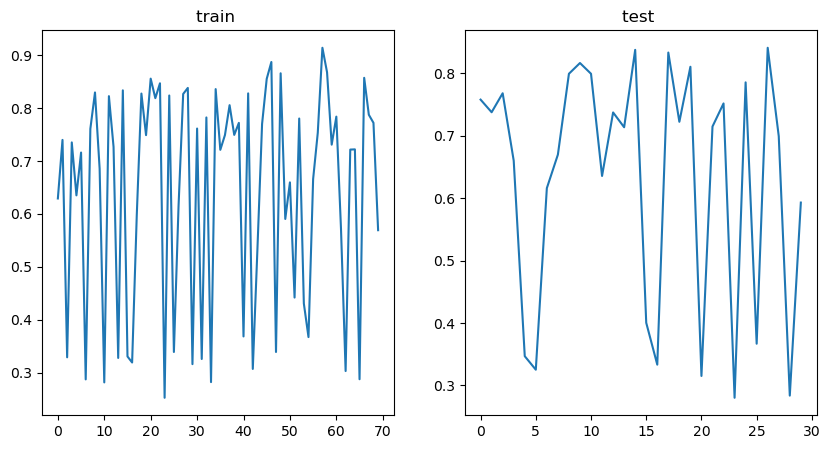

In [13]:
data = [predictions_train.predictions,predictions_test.predictions]
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10, 5))

axs[0].plot(data[0],label='train')
axs[0].title.set_text('train ')

axs[1].plot(data[1],label='train')
axs[1].title.set_text('test ')

In [14]:
print(f'key\t\t train.metric \t test.metrics')

for key in list(predictions_test.metrics.keys())[:2]:
    print(f'{key} \t\t{predictions_train.metrics[key]:0.3f} \t\t{predictions_test.metrics[key]:0.3f}')

key		 train.metric 	 test.metrics
test_loss 		0.066 		0.073
test_rmse 		0.258 		0.270


## Save And Load The Pre-Trained Model And Tokenizer


In [147]:
# save the model/tokenizer

model.save_pretrained("model")
tokenizer.save_pretrained("tokenizer")

# load the model/tokenizer

from transformers import AutoModelForTokenClassification
model = AutoModelForSequenceClassification.from_pretrained("model")
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

Configuration saved in model/config.json
Model weights saved in model/pytorch_model.bin
tokenizer config file saved in tokenizer/tokenizer_config.json
Special tokens file saved in tokenizer/special_tokens_map.json
loading configuration file model/config.json
Model config DistilBertConfig {
  "_name_or_path": "model",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "vocab_size": 30581
}

loading weights file model/pytorch_model.bin
All mod

##  Use The Model

In [148]:
from transformers import Trainer
trainer = Trainer(model=model)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True) 

def pipeline_prediction(text):
    df=pd.DataFrame({'text':[text]})
    dataset = Dataset.from_pandas(df,preserve_index=False) 
    tokenized_datasets = dataset.map(tokenize_function)
    raw_pred, _, _ = trainer.predict(tokenized_datasets) 
    return(raw_pred[0][0])

pipeline_prediction("🚨 Get 50% now!")

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


  0%|          | 0/1 [00:00<?, ?ex/s]

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1
  Batch size = 8


0.49922305